#### Setup

In [13]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

import pandas as pd

from sentinelhub import SHConfig

config = SHConfig()

#### Loading the Data

In [31]:
absdorf_bbox_coords = [15.969363,48.405107,15.972641,48.406845]
absdorf_bbox_coords = [
  15.968838,
  48.404456,
  15.975341,
  48.408053
]
au_am_leitha_1_bbox_coords = [16.529000,47.930621,16.533941,47.932141]
resolution = 60
absdorf_bbox = BBox(bbox=absdorf_bbox_coords, crs=CRS.WGS84)
absdorf_bbox_size = bbox_to_dimensions(absdorf_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {absdorf_bbox_size} pixels")

Image shape at 60 m resolution: (8, 7) pixels


In [6]:
with open("Datasets/bestand_31_10_22.csv") as file:
        bestand = pd.read_csv(file)

In [10]:
# Add the coords to the df (with weird string workaround since lists dont go into cells with loc)
bestand.loc[bestand['SITE'] == "Abs", 'BoundingBox'] =  f"{absdorf_bbox_coords}"
bestand.loc[bestand['SITE'] == "Au1", 'BoundingBox'] =  f"{au_am_leitha_1_bbox_coords}"

In [12]:
# update the file
bestand.to_csv("Datasets/bestand_31_10_22.csv")

#### Retrieving the satellite data

In [32]:
from typing import Any, Optional, Tuple

def plot_image(
    image: np.ndarray, factor: float = 1.0, clip_range: Optional[Tuple[float, float]] = None, **kwargs: Any
) -> None:
    """Utility function for plotting RGB images."""
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

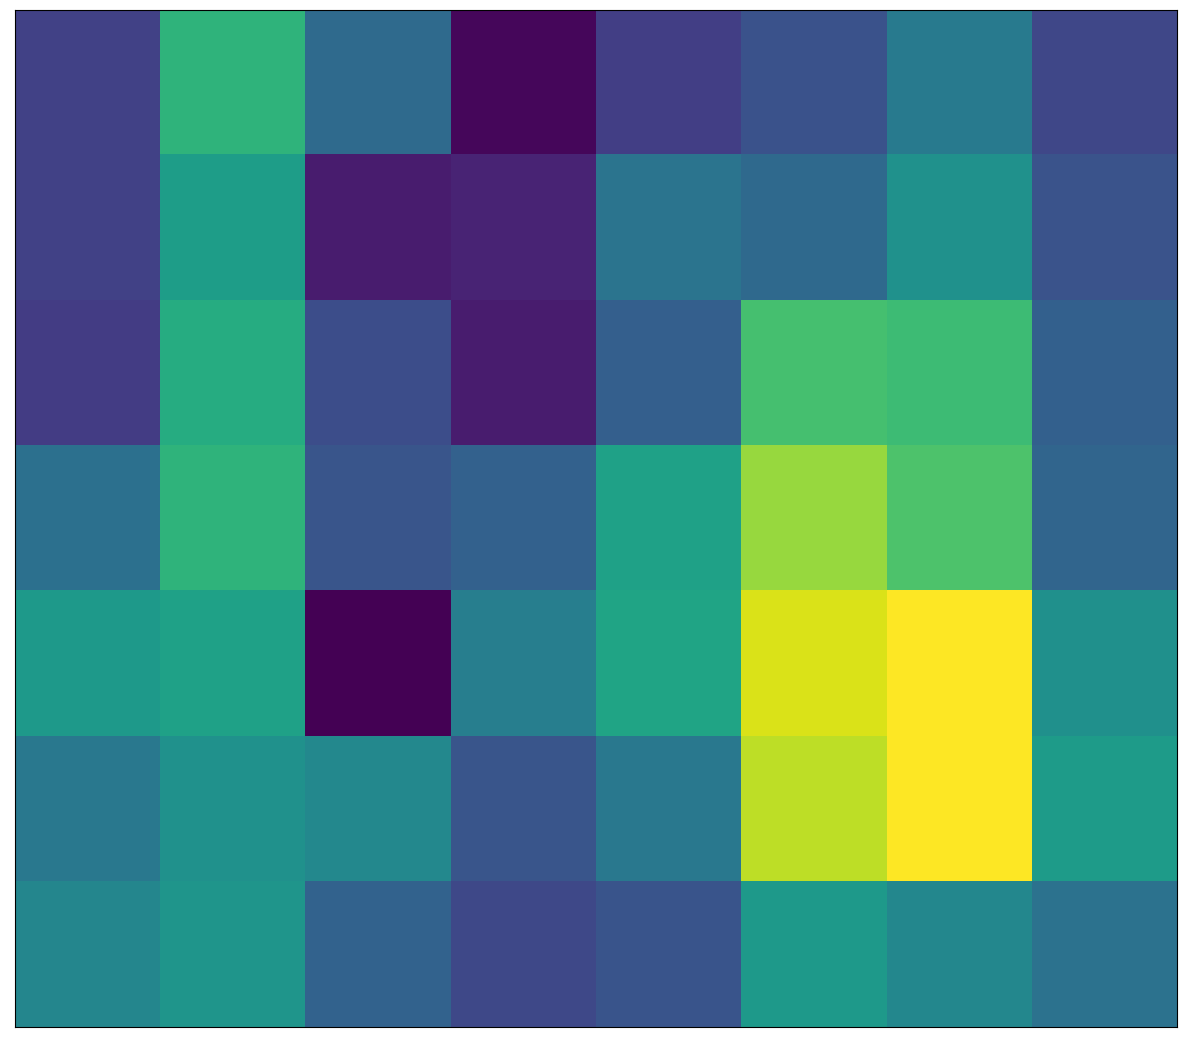

In [33]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {
        return {
            input: [{
                bands: ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B10","B11","B12"],
                units: "DN"
            }],
            output: {
                bands: 13,
                sampleType: "INT16"
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B01,
                sample.B02,
                sample.B03,
                sample.B04,
                sample.B05,
                sample.B06,
                sample.B07,
                sample.B08,
                sample.B8A,
                sample.B09,
                sample.B10,
                sample.B11,
                sample.B12];
    }
"""

request_all_bands = SentinelHubRequest(
    data_folder="SatelliteImages",
    evalscript=evalscript_all_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-01", "2020-06-30"),
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=absdorf_bbox,
    size=absdorf_bbox_size,
    config=config,
)

all_bands_response = request_all_bands.get_data(save_data=True)

# Image showing the SWIR band B12
# Factor 1/1e4 due to the DN band values in the range 0-10000
# Factor 3.5 to increase the brightness
plot_image(all_bands_response[0][:, :, 12], factor=3.5 / 1e4, vmax=1)

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (7, 8, 3)
Image type: uint8


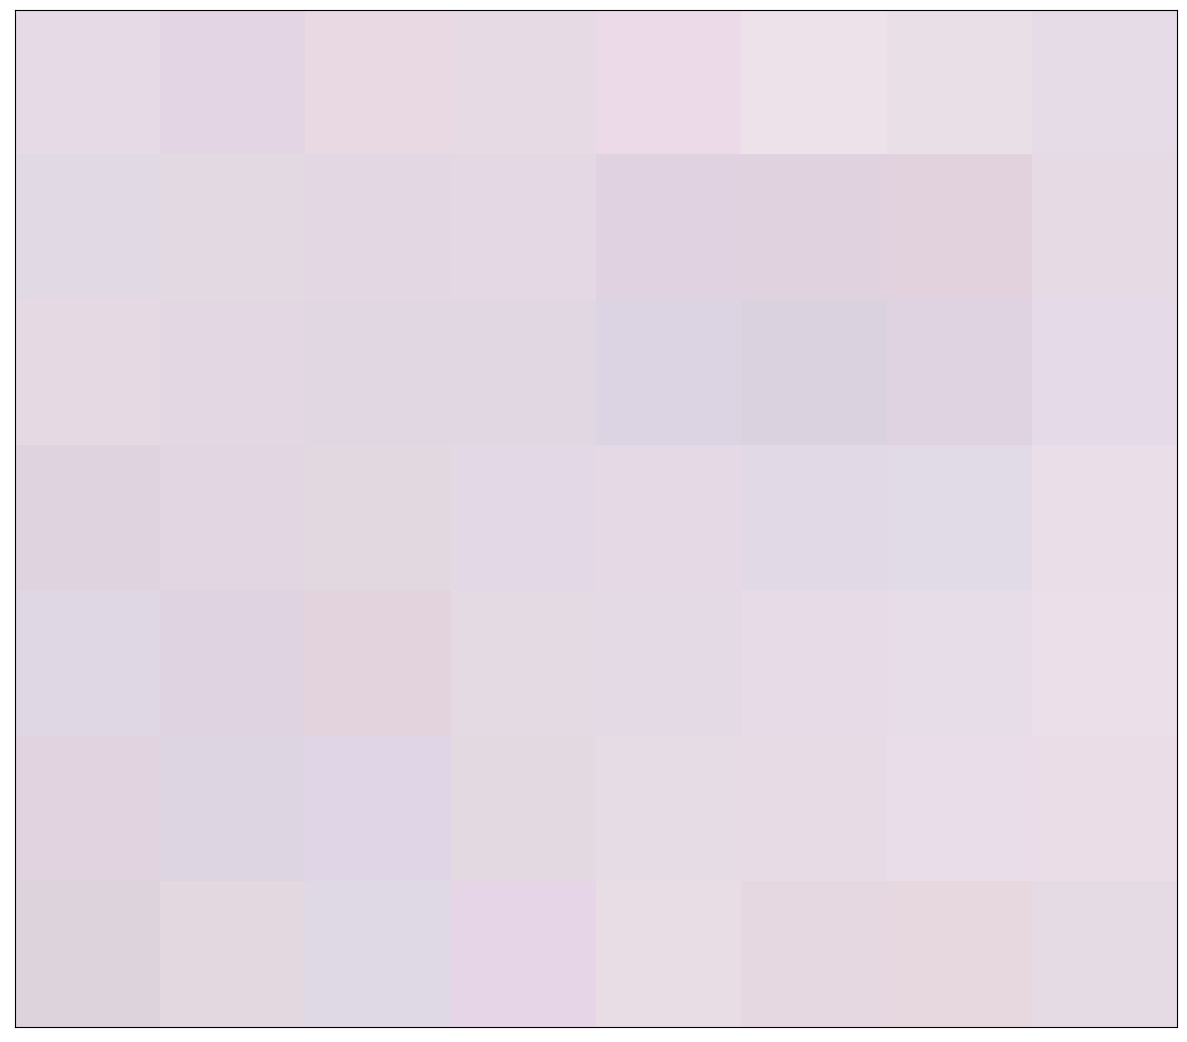

In [52]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-01", "2020-06-30"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=absdorf_bbox,
    size=absdorf_bbox_size,
    config=config,
)

true_color_imgs = request_true_color.get_data()

print(f"Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}.")
print(f"Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}")
image = true_color_imgs[0]
print(f"Image type: {image.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(image, factor=1 / 255, clip_range=(0, 1))